# Exploratory Data Analysis

## Import Libraries

In [43]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import yaml
from pathlib import Path
import pickle
import os

from scipy.stats import chi2_contingency
from sklearn.feature_selection import VarianceThreshold

from src.config import config
from src.utils import read_data, nulls_summary_table, pickle_save, pickle_load

In [2]:
%load_ext autoreload
%autoreload 2

## Import Data

- We will remove 'id' as it is just a running number and hence it does not contribute to the prediction
- We will rename the columns so that is is easier for data manipulation

In [3]:
df_train = read_data("train_data")
df_test = read_data("test_data")

## Data Type

In [4]:
df_train.dtypes

ProductID              object
Type                   object
AirTemperature        float64
ProcessTemperature    float64
RotationalSpeed         int64
Torque                float64
ToolWear                int64
MachineFailure          int64
TWF                     int64
HDF                     int64
PWF                     int64
OSF                     int64
RNF                     int64
dtype: object

In [5]:
df_train.TWF = df_train.TWF.astype(object)
df_train.HDF = df_train.HDF.astype(object)
df_train.PWF = df_train.PWF.astype(object)
df_train.OSF = df_train.OSF.astype(object)
df_train.RNF = df_train.RNF.astype(object)
df_train.MachineFailure = df_train.MachineFailure.astype(object)

In [6]:
numeric_columns=list(df_train.select_dtypes(include=np.number).columns)
categorical_columns=list(df_train.select_dtypes(exclude= np.number).columns)

In [7]:
def shape_of_df(df):
    print(f"There are {df.shape[0]} rows and {df.shape[1]} columns")

In [8]:
shape_of_df(df_train)
shape_of_df(df_test)

There are 136429 rows and 13 columns
There are 90954 rows and 12 columns


## Missing Values

There are no missing values in the dataset

In [9]:
nulls_summary_table(df_train)

,null_count,null_pct
ProductID,0,0.0
Type,0,0.0
AirTemperature,0,0.0
ProcessTemperature,0,0.0
RotationalSpeed,0,0.0
Torque,0,0.0
ToolWear,0,0.0
MachineFailure,0,0.0
TWF,0,0.0
HDF,0,0.0


## Distributions

### Target Variable

- The data is imbalanced. We should select a metric that can account for imbalance data.
- Target Variable is Categorical. This is a classification problem.
- Since data is imbalanced, to ensure that the ratio of labels in each K-Fold is constant, we will use Stratified K-Fold

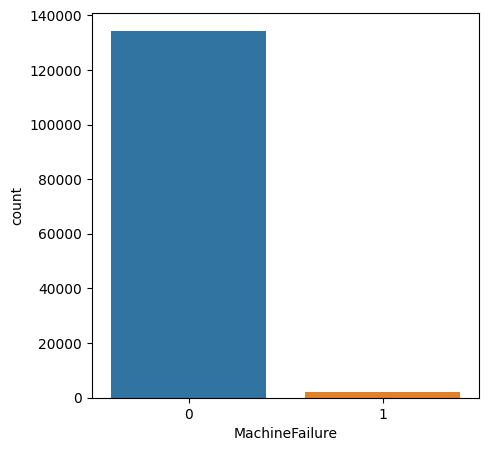

In [10]:
df_machine_failure_count = (df_train
                            .MachineFailure
                            .value_counts()
                            .reset_index()
)

plt.figure(figsize=(5,5))
sns.barplot(data=df_machine_failure_count, x="MachineFailure", y="count")
plt.show()

### Numerical Columns

Tree-based models such as Decision Trees, Random Forest, Gradient Boosting, XGBoost, and others are not affected by the distribution of the data. Hence, we do not have to transform them into a normal distribution

In [12]:
# Distribution for both machine failure == 0 and 1
def plot_dist_numerical_cols(df, title, numeric_columns):
    xaxes = numeric_columns

    f, ax = plt.subplots(2,3, figsize=(12,6))
    a = ax.ravel()
    for idx, ax in enumerate(a):
        if idx != 5:
            sns.histplot(ax=ax, data=df, x=xaxes[idx], kde=True)
    
    f.suptitle(title, fontsize=15)
    plt.show()

In [13]:
def plot_dist_separate_numeric_cols(df, numeric_columns):
    xaxes = numeric_columns

    df_train_machines_fail = df.query("MachineFailure == 1")
    df_train_machines_pass = df.query("MachineFailure == 0")

    f, axes = plt.subplots(5,2, figsize=(12,25))

    for idx, ax in enumerate(xaxes):
        if (idx != 5):
            sns.histplot(ax=axes[idx, 0], data=df_train_machines_pass, x=xaxes[idx], kde=True, color='green')
            axes[idx, 0].set_title("Machine == Pass")

            sns.histplot(ax=axes[idx, 1], data=df_train_machines_fail, x=xaxes[idx], kde=True, color='red')
            axes[idx, 1].set_title("Machine == Fail")

    #f.suptitle(title, fontsize=15)
    plt.show()

In [14]:
def correlation_with_target(df, cols):
    target_cols = cols + ['MachineFailure']
    df_train_target = df.loc[:, target_cols]
    corr = df_train_target.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True,
                          annot=True)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
    plt.show()

- Torque and RotationalSpeed are strongly negatively correlated
- ProcessTemperature and AirTemperature are strongly positive correlated

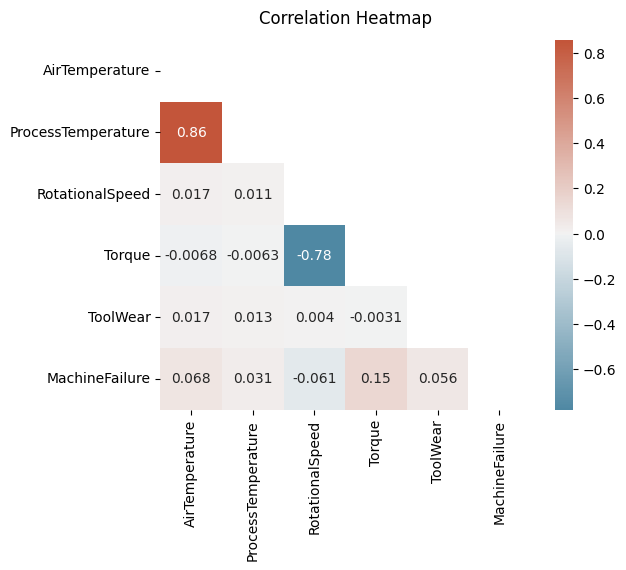

In [15]:
correlation_with_target(df_train, numeric_columns)

- In case there are non linear relationship, we should check the scatterplot
- From the pairwise plot, it seems that whenever Torque is too low or too high, we get frequent machine failure.
- Whenever rotational speed is too high, we get frequent machine failure

In [16]:
cols = numeric_columns + ['MachineFailure']
df_train_numerical = df_train.loc[:,cols]

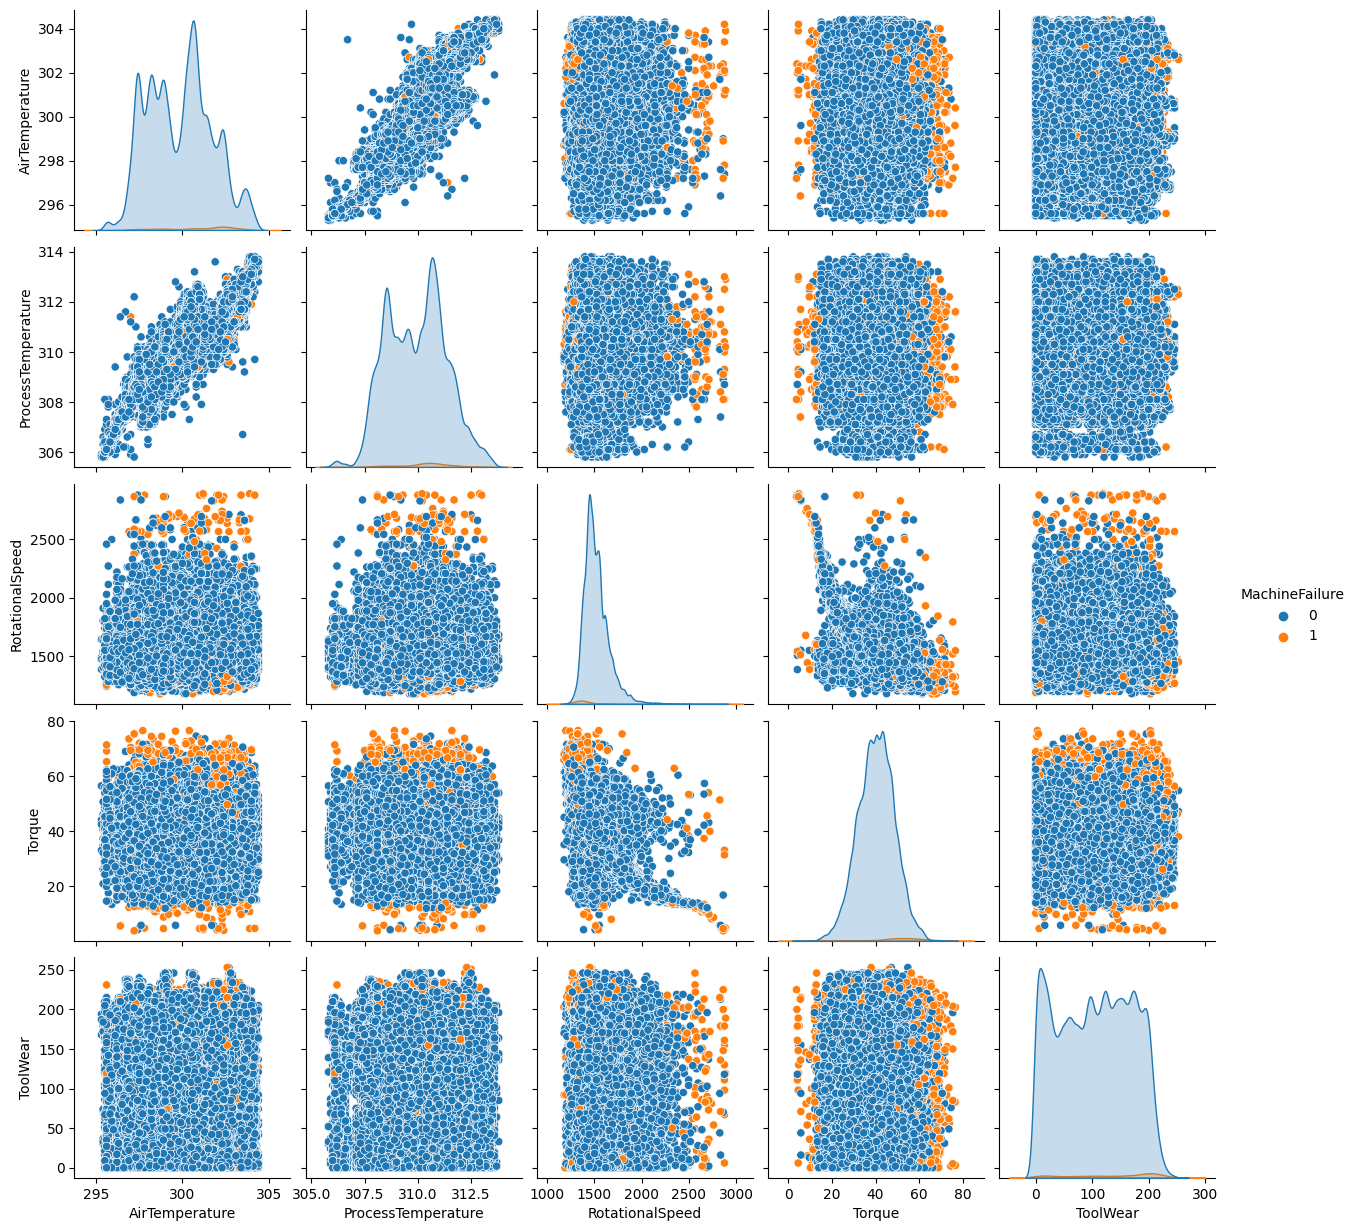

In [17]:
sns.pairplot(df_train_numerical, hue='MachineFailure')

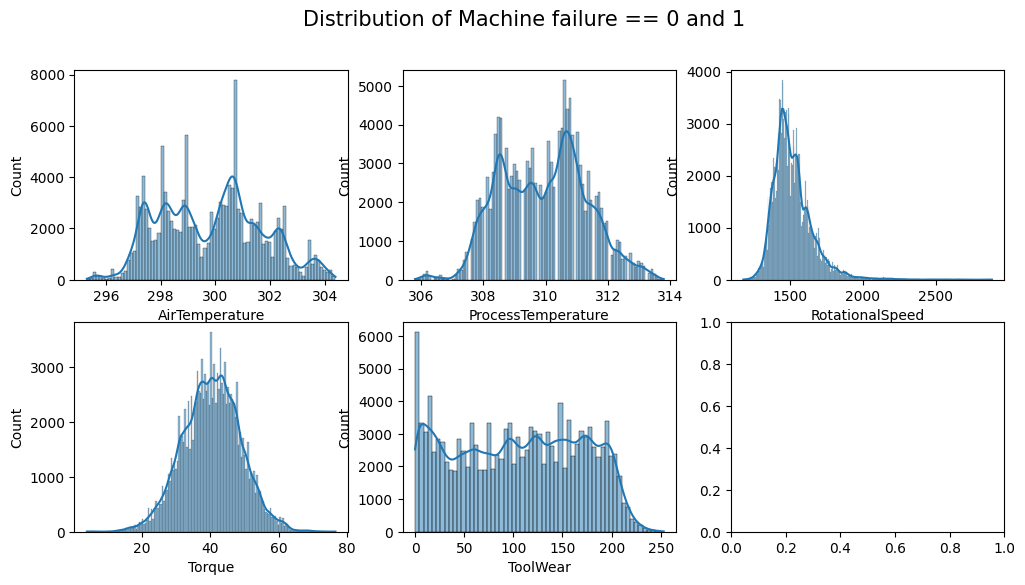

In [18]:
plot_dist_numerical_cols(df_train, "Distribution of Machine failure == 0 and 1", numeric_columns)

There are some differences in the distribution between machine that passes and fails
- **AirTemperature**: Machine that fails have higher temperature
- **RotationalSpeed**: Machine that fails usually have lower speed
- **Torque**: Machine that fails usually have higher torque

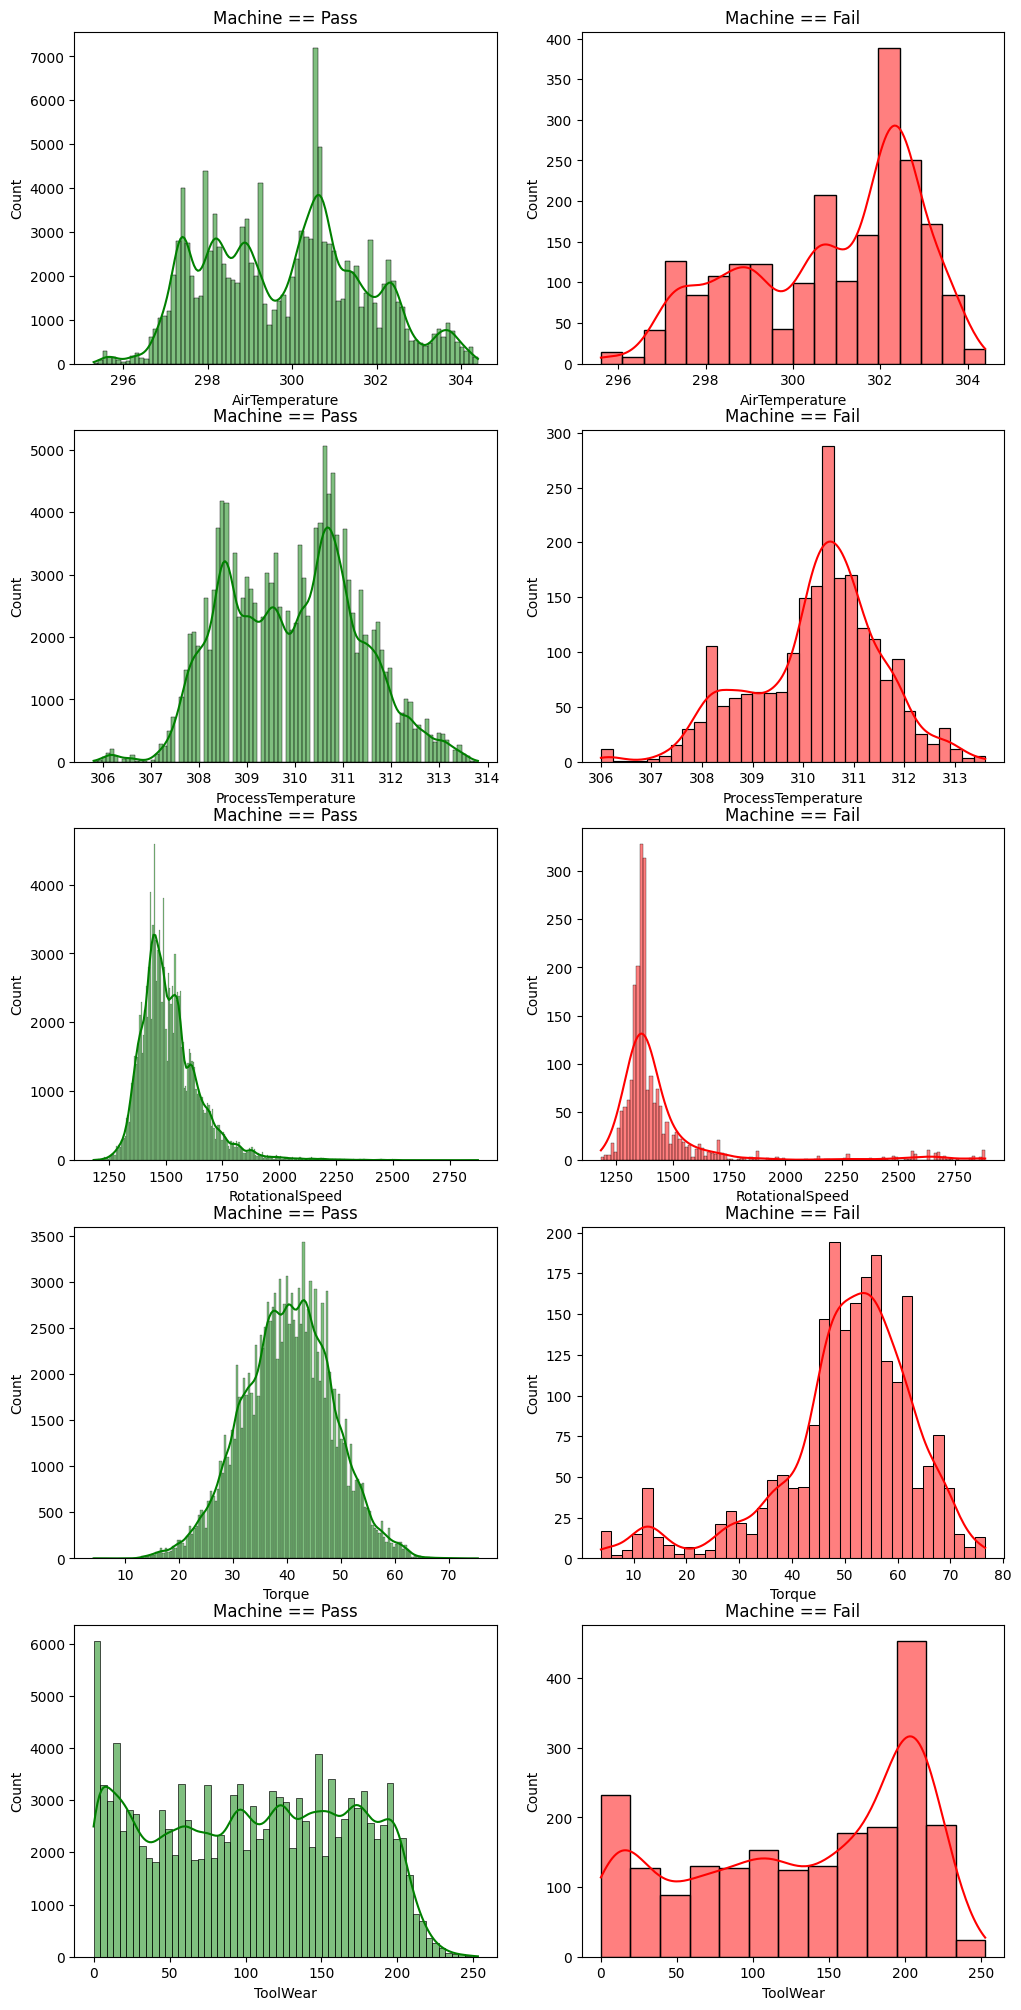

In [19]:
plot_dist_separate_numeric_cols(df_train, numeric_columns)

### Categorical Columns

#### Type

All three types have similar machine failure probability

In [20]:
def pivot_type_var(df_train: pd.DataFrame) -> pd.DataFrame:
    """Pivot Type and MachineFailure columns.
    Creates additional 'Total', 'Suceeed %' and 'Failure %'

    Args:
        df_train (pd.DataFrame): training data

    Returns:
        pd.DataFrame: Pivoted dataframe
    """
    type_target_count = (df_train
                     .groupby(["Type", "MachineFailure"])
                     .ProductID
                     .count()
                     .reset_index()
)
    type_target_count_unmelted = type_target_count.pivot(index='Type', columns='MachineFailure')
    type_target_count_unmelted.columns.name = None
    type_target_count_unmelted = (type_target_count_unmelted
                                .ProductID
                                .reset_index()
                                .rename(columns={0: 'Succeed',
                                                1: 'Fail',
                                                'MachineFailure': 'Index'})
    )
    total = type_target_count_unmelted.loc[:, ['Succeed', 'Fail']].sum(axis=1)
    type_target_count_unmelted = (type_target_count_unmelted
                                .assign(Total=total,
                                        Succeed_Percentage=lambda df_: df_.Succeed/df_.Total*100,
                                        Fail_Percentage=lambda df_: df_.Fail/df_.Total*100))
    return type_target_count_unmelted


In [21]:
type_target_count_unmelted = pivot_type_var(df_train)

In [22]:
def plot_type_fail_percentage(type_target_count_unmelted):
    fig, ax = plt.subplots(figsize=(5, 5))
    x_pos_for_H = round(type_target_count_unmelted.query("Type=='H'").Fail_Percentage.values[0],2)
    x_pos_for_L = round(type_target_count_unmelted.query("Type=='L'").Fail_Percentage.values[0],2)
    x_pos_for_M = round(type_target_count_unmelted.query("Type=='M'").Fail_Percentage.values[0],2)
    x_pos = [x_pos_for_H, x_pos_for_L, x_pos_for_M]

    sns.set_color_codes("pastel")
    sns.barplot(x="Succeed_Percentage", y="Type", data=type_target_count_unmelted,
                label="Did not fail", color="b")
    sns.set_color_codes("muted")
    sns.barplot(x="Fail_Percentage", y="Type", data=type_target_count_unmelted,
                label="Fail", color="b")

    ytick_loc  = {v.get_text(): v.get_position()[1] for v in ax.get_yticklabels()}
    xtick_loc  = {v.get_text(): v.get_position()[1] for v in ax.get_xticklabels()}

    temp = 0
    for idx, key in enumerate(ytick_loc):
        value = str(round(type_target_count_unmelted.Fail_Percentage[idx],3)) + '%'
        y_pos = 0.99 - temp
        ax.annotate(value, xy=(x_pos[idx], ytick_loc[key]), xycoords='data',
                    xytext=(0.1, y_pos), textcoords='axes fraction',
                    va='top', ha='left',
                    arrowprops=dict(facecolor='black', shrink=0.05))
        temp += 0.4

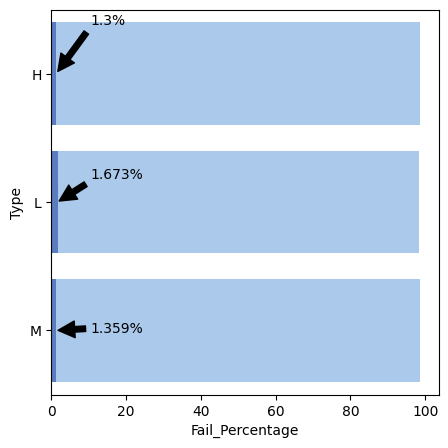

In [23]:
plot_type_fail_percentage(type_target_count_unmelted)

### ProductID

We will use Frequency Encoder to encode this column

https://github.com/PlayingNumbers/ML_Process_Course/blob/main/README.md

In [24]:
class FrequencyEncoder:
    def fit(self, df_train, column):
        self.df_train = df_train
        self.column = column
    
    def transform(self, df_test, column):
        frequency_encoded = self.df_train.groupby([self.column]).size()

        col_name = column + '_freq'
        df_test.loc[:, col_name] = df_test[column].apply(lambda x: frequency_encoded[x])
        return df_test

In [25]:
fe = FrequencyEncoder()
fe.fit(df_train, column='ProductID')
df_freq_enc = fe.transform(df_train, column='ProductID')
df_freq_enc.head()

,ProductID,Type,AirTemperature,ProcessTemperature,RotationalSpeed,Torque,ToolWear,MachineFailure,TWF,HDF,PWF,OSF,RNF,ProductID_freq
0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,25
1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,20
2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,33
3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0,29
4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0,8


In [42]:
df_freq_enc.loc[:, ['ProductID_freq', 'MachineFailure']].corr()

,ProductID_freq,MachineFailure
ProductID_freq,1.000000,-0.018058
MachineFailure,-0.018058,1.000000


In [26]:
# train_product_count = df_train.groupby(['ProductID'])['Type'].count().reset_index()
# dict_train_product_count = dict(zip(train_product_count.ProductID, train_product_count.Type))
# pickle_save(dict_train_product_count, pickle_path, "dict_train_product_count")

### TWF, HDF, PWF, OSF, RNF

We will build a contingency table

$H_{0}$: The effect of TWF and MachineFailure are independent   
$H_{1}$: The effect of TWF and MachineFailure are dependent

In [27]:
def compute_chi2(col):
    crosstab = pd.crosstab(df_train[col],
                           df_train['MachineFailure'])
    table = crosstab.to_numpy()
    res = chi2_contingency(table)
    return res.pvalue, table

In [28]:
compute_chi2('TWF')

(0.0,
 array([[134281,   1936],
        [     0,    212]], dtype=int64))

In [29]:
compute_chi2('HDF')

(0.0,
 array([[134275,   1450],
        [     6,    698]], dtype=int64))

In [30]:
compute_chi2('PWF')

(0.0,
 array([[134278,   1824],
        [     3,    324]], dtype=int64))

In [31]:
compute_chi2('OSF')

(0.0,
 array([[134277,   1612],
        [     4,    536]], dtype=int64))

In [32]:
compute_chi2('RNF')

(0.7655628412798019,
 array([[133979,   2142],
        [   302,      6]], dtype=int64))

All except 'RNF' seems to have a relationship with the target variable

In [33]:
print(f"The p-value of 'TWF' is {compute_chi2('TWF')}")
print(f"The p-value of 'HDF' is {compute_chi2('HDF')}")
print(f"The p-value of 'PWF' is {compute_chi2('PWF')}")
print(f"The p-value of 'OSF' is {compute_chi2('OSF')}")
print(f"The p-value of 'RNF' is {compute_chi2('RNF')}")

The p-value of 'TWF' is (0.0, array([[134281,   1936],
       [     0,    212]], dtype=int64))
The p-value of 'HDF' is (0.0, array([[134275,   1450],
       [     6,    698]], dtype=int64))
The p-value of 'PWF' is (0.0, array([[134278,   1824],
       [     3,    324]], dtype=int64))
The p-value of 'OSF' is (0.0, array([[134277,   1612],
       [     4,    536]], dtype=int64))
The p-value of 'RNF' is (0.7655628412798019, array([[133979,   2142],
       [   302,      6]], dtype=int64))


In [34]:
cat_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

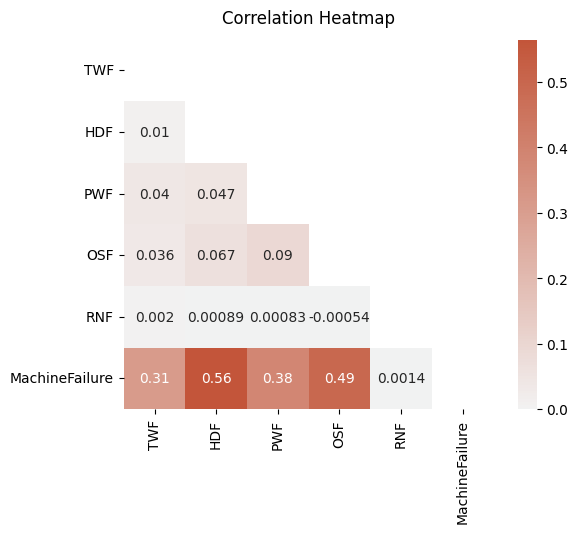

In [35]:
correlation_with_target(df_train, cat_cols)

## Data Processing

### Feature Engineering

- We will perform frequency encoding on "ProductID" since it has high cardinality
- We will perform one-hot encoding on "Type" since there are only three types
- We will not have to scale our data as we are using tree based methods for data modeling.

### Feature Selection

- The numerical columns all seemed to have some form of relationship with the other numerical columns so we shall keep all of the columns.
- For the newly create ``ProductID_freq`` column, it seems like the correlation is close to 0. Hence, we will also drop it
- For the categorical columns, "RNF" seems to have almost 0 correlation with our target variable. Hence, we will drop it.